# Test function on images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Unpickle camera calibration data
with open("./camera_cal/calibration_data.p",'rb') as cal_f:
    calibration_data = pickle.load(cal_f) 
mtx = calibration_data['mtx']
dist = calibration_data['dist']

In [3]:
# Load all images
images = glob.glob("./test_images/*.jpg")

In [4]:
images

['./test_images/straight_lines1.jpg',
 './test_images/test2.jpg',
 './test_images/straight_lines2.jpg',
 './test_images/test4.jpg',
 './test_images/test1.jpg',
 './test_images/test6.jpg',
 './test_images/test5.jpg',
 './test_images/test3.jpg']

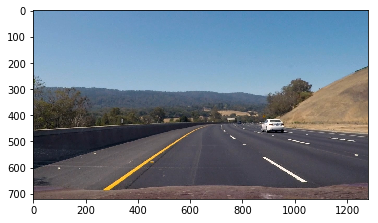

In [39]:
sample_img = mpimg.imread(images[7])
plt.imshow(sample_img)

### 1. Undistort image

In [40]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

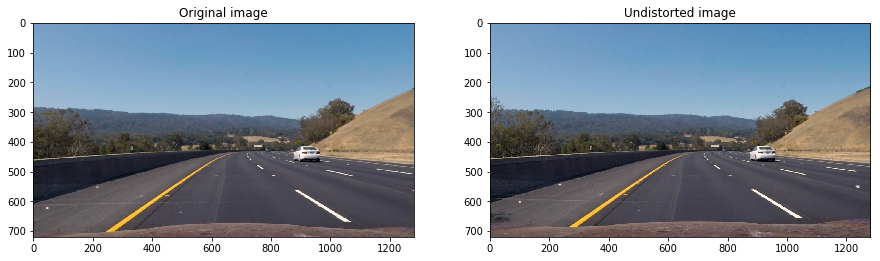

In [41]:
undist_img = undistort(sample_img, mtx, dist)
f, axs = plt.subplots(1,2, figsize=(15,30))
axs[0].imshow(undist_img)
axs[0].set_title("Original image")
axs[1].imshow(sample_img)
axs[1].set_title("Undistorted image")
plt.show()

### 2. Color and Gradient Trasformations

In [42]:
def sobel_filter(img, mode='x', low_thresh=0, high_thresh=255, kernel=3):
    
    # Select mode between gradient in x or y, magnitude and direction
    if mode in ['x','y','mag']:
        
        x_flag = int(mode == 'x')
        y_flag = int(mode == 'y')  
        if x_flag or y_flag:
            sobel_out = cv2.Sobel(img, cv2.CV_64F, x_flag, y_flag, ksize=kernel)
            abs_sobel = np.abs(sobel_out)
        else:
            sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
            sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
            abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        # Threshold absolute gradient
        sobel_binary = np.zeros_like(scaled_sobel)
        sobel_binary[(scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh)] = 1
        
    else:
        print("Sobel param 'mode' must correnspond to one of the following values: 'x','y','mag','dir'")
        sys.exit(-1)
    
    return sobel_binary

In [43]:
def color_filter(img, low_thresh, high_thresh):
    color_binary = np.zeros_like(img)
    color_binary[(img >= low_thresh) & (img <= high_thresh)] = 1
    return color_binary

In [44]:
def color_gradient_transform(img, transforms, comb_function):
    """
    Perform color and gradient transformations and return binary image according to the given thresholds.
    
    The image can undergo both/either one color transformation and/or one Sobel transformation.
    
    It takes as input an RGB image and a list a dictionaries containing the transformation parameters.
    
    Please convert BGR to RGB!
    
    Color Params:
    - type: set to 'color'
    - channel: rgb or hls, gray: 'r','g','b', 'h', 'l','s', 'gray'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    
    Sobel Params:
    - s
    - mode: x, y, m, dir
    - channel: rgb or hls 'r','g','b', 'h', 'l','s'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    - kernel: kernel size of sobel filter, must be an odd number 
    """
    
    # Compute color transformations only if required by a filter
    img_channel = {}
    channels = set([])
    for params in transforms:
        if params:
            channels = channels.union({params['channel']})
            
    if channels & {'h','l','s'}:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_channel['h'] = hls[:,:,0]
        img_channel['l'] = hls[:,:,1]
        img_channel['s'] = hls[:,:,2]
        
    if channels & {'r','g','b'}:
        img_channel['r'] = img[:,:,0]
        img_channel['g'] = img[:,:,1]
        img_channel['b'] = img[:,:,2]
        
    if 'gray' in channels:
        img_channel['gray'] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    imgs = [np.zeros_like(img[:,:,0])]
        
    # Compute required filters
    for params in transforms:
        if params['type'] == 'sobel':
            imgs.append(sobel_filter(img_channel[params['channel']], params['mode'],
                                       params['low_thresh'], params['high_thresh'],
                                       params['kernel']))
        elif params['type'] == 'color':
            imgs.append(color_filter(img_channel[params['channel']],
                                       params['low_thresh'], params['high_thresh']))
            
    
    cgt_img = comb_function(imgs)
    
    return cgt_img

In [45]:
def comb_function(imgs):
    combi = imgs[0]
    combi[((imgs[1] == 1) & (imgs[2] == 1)) | (imgs[3] == 1)] = 1
    return combi

In [46]:
sobelxparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'x',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

sobelyparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'y',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

colorparams = {
    'type': 'color',
    'channel': 's',
    'low_thresh': 150,
    'high_thresh': 255
}

filter_params = [sobelxparams, sobelyparams, colorparams]
combi = color_gradient_transform(undist_img, filter_params, comb_function)

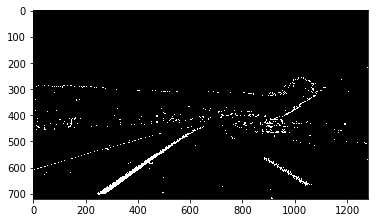

In [47]:
plt.imshow(combi, cmap='gray')
plt.show()

### 2.5. Region Masking

In [ ]:
vertices = 

### 3. Perspective transform 

In [48]:
def perspective_transform(img, M, transf=cv2.INTER_LINEAR):
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=transf)
    return warped

Transformation matrix is supposed to be calculated only once since the masking region is always the same

In [49]:
imshape = combi.shape # [y, x]
trap_topwidth = 0.1
trap_bottomwidth = .7
trap_height = 0.37
warp_offset = .57
bottom_offset = 0.08
# src and s
src = np.float32([[imshape[1] * (1 - trap_bottomwidth)/2,imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_bottomwidth)/2, imshape[0]*(1 - bottom_offset)]])
dst = np.float32([[imshape[1] * (1 - warp_offset)/2, imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - warp_offset)/2, 0],
                  [imshape[1] * (1 + warp_offset)/2, 0],
                  [imshape[1] * (1 + warp_offset)/2, imshape[0]*(1 - bottom_offset)]])

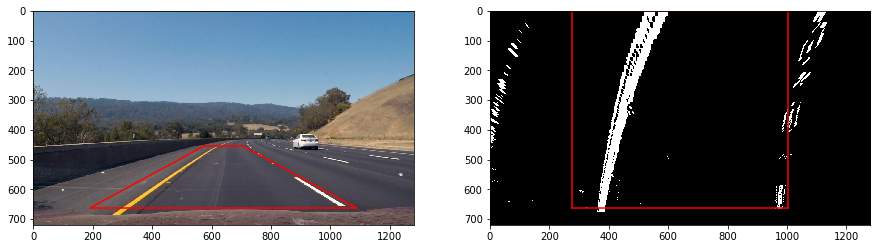

In [50]:
M = cv2.getPerspectiveTransform(src, dst)
warped_img = perspective_transform(combi, M)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,30))

ax1.imshow(sample_img)
ax1.plot(src[0:2,0], src[0:2,1],c='r')
ax1.plot(src[1:3,0], src[1:3,1],c='r')
ax1.plot(src[2:4,0], src[2:4,1],c='r')
ax1.plot(src[[0,3],0], src[[0,3],1],c='r')

ax2.imshow(warped_img, cmap='gray')
ax2.plot(dst[0:2,0], dst[0:2,1],c='r')
ax2.plot(dst[1:3,0], dst[1:3,1],c='r')
ax2.plot(dst[2:4,0], dst[2:4,1],c='r')
ax2.plot(dst[[0,3],0], dst[[0,3],1],c='r')

plt.show()

### 4. Histogram ans sliding window

In [51]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [52]:
def fit_polynomial(binary_warped, viz_flag=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Generate x and y values for plotting
    if viz_flag:
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img, cmap='gray')

    return left_fit, right_fit, ploty

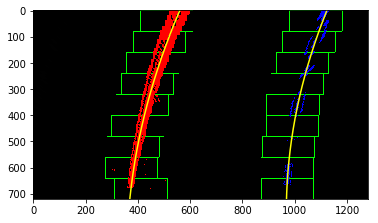

In [53]:
left_fit, right_fit, ploty = fit_polynomial(warped_img, True)

###  5. Search from prior

Only images, can't test this here!

###  6. Sanity check

In [54]:
def sanity_check(left_coeffs, right_coeffs):
    # To be implemented
    return True

### 7. Measure curvature and offset

In [55]:
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)  * ym_per_pix
    
    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**(3/2) / np.abs(2*left_fit_cr[0])
    right_curverad =(1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**(3/2) / np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [56]:
left_curverad_real, right_curverad_real = measure_curvature_real(left_fit, right_fit, ploty)

(left_curverad_real, right_curverad_real)

(2804.043175506738, 2356.4225929222039)

### 8. Draw lines on image

In [82]:
def draw_lines(frame, binary_warped, Minv, left_fit, right_fit):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Prepare data
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    
    return result

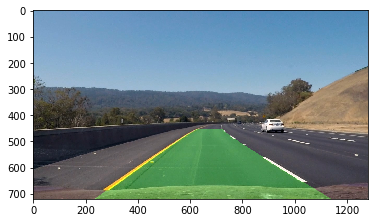

In [83]:
Minv = cv2.getPerspectiveTransform(dst, src)
final_img = draw_lines(sample_img, warped_img, Minv, left_fit, right_fit)
plt.imshow(final_img)

# Refactoring code to process video stream

In [84]:
def warp_from_frame(img, mtx, dist, filter_params, comb_function, M):
    
    undist_img = undistort(img, mtx, dist)
    binary_img = color_gradient_transform(undist_img, filter_params, comb_function)
    warped_img = perspective_transform(binary_img, M)
    
    return warped_img

In [85]:
def sliding_window(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [90]:
class Processor():
    """ 
    The purpose of this class is to store all the hyperparameters and previous lane data as attributes, so that 
    the process_frame method can be passed to the movie processor and access all such attributes.
    
    It is initalized with all the hyperparameters necessary at the various steps.
    
    Call the reset_lines method before processing a new video when reusing the same Processor object on more videos
    """
    
    def __init__(self, mtx, dist, filter_params, comb_function, M, Minv):
        self.mtx = mtx
        self.dist = dist
        self.filter_params = filter_params
        self.comb_function = comb_function
        self.M = M
        self.Minv = Minv
        self.first_frame = None
        self.right_line = Line()
        self.left_line = Line()
        self.first_frame = True
        
    def reset_lines(self):
        self.right_line = Line()
        self.left_line = Line()
        self.first_frame = True
    
    def process_frame(self, frame):
        
        # First steps, unconditionally necessary
        binary_warped = warp_from_frame(frame, self.mtx, self.dist, self.filter_params, 
                                        self.comb_function, self.M)
        
        # Attempt to search from prior, otherwise use sliding window
        if self.first_frame:
            right_coeffs, left_coeffs = sliding_window(binary_warped)
            self.first_frame = False
            self.left_line.update(left_coeffs)
            self.right_line.update(left_coeffs)
        else:
            try:
                right_coeffs, left_coeffs = search_from_prior(binary_warped)
            except:
                right_coeffs, left_coeffs = sliding_window(binary_warped)
        
            # Apply new data if sanity check results ok
            if sanity_check(left_coeffs, right_coeffs):
                self.left_line.update(left_coeffs)
#                 print("b"+str(self.left_line.coeffs))
                self.right_line.update(right_coeffs)
            else:
                self.left_line.update_without()
                self.right_line.update_without()
                
        annotated_frame = draw_lines(frame, binary_warped, self.Minv,
                                     self.left_line.coeffs, self.right_line.coeffs)
        
        return annotated_frame

In [95]:
class Line():
    
    def __init__(self, n_frames=10):
        # Current polynomial coefficients
        self.detected = 0
        self.undetected = 0
        self.coeffs = None
        self.coeffs_array = np.empty([1,3])
        self.n_frames = n_frames
        pass
    
    def update(self, coeffs):
        
        self.detected = self.detected + 1
        self.coeffs_array = np.vstack([self.coeffs_array, coeffs])
        
        # Average filter
        span_avg = self.n_frames if self.n_frames < self.coeffs_array.size+1 else self.coeffs_array.size-1
        newcoeffs = np.mean(self.coeffs_array[-span_avg:,:], axis=0)
        self.coeffs = newcoeffs
        self.coeffs_array = np.vstack([self.coeffs_array, newcoeffs])
        
        # Remove to activate filter
#         self.coeffs = coeffs
#         print("a"+str(coeffs))
    
    def update_without(self):
        self.undetected = self.undected + 1
        self.detected = 0

In [96]:
proc = Processor(mtx, dist, filter_params, comb_function, M, Minv)
video_output = 'challennge_video_lanes.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(proc.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challennge_video_lanes.mp4
[MoviePy] Writing video challennge_video_lanes.mp4


100%|██████████| 485/485 [01:41<00:00,  4.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challennge_video_lanes.mp4 

CPU times: user 45.4 s, sys: 11.9 s, total: 57.4 s
Wall time: 1min 44s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [31]:
a = np.empty([1,3])
b = np.array([1,2,3])

In [32]:
a = np.vstack((a, b))
a

array([[ 1.69566204,  0.35226375,  0.02530776],
       [ 1.        ,  2.        ,  3.        ]])